# Install Tensorflow

**Install Tesorflow**


In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0.post1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [ ]:
!pip install tensorflow

In [ ]:
!pip install tensorflow --upgrade

# Pre-Processing Data

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Cek Label diDataset**

In [ ]:
train_dir = '/content/drive/MyDrive/DataSet_Revisi_Sidang'
dir_healthy = os.path.join(train_dir, 'Healthy')
dir_common_rust = os.path.join(train_dir, 'Common_Rust')
dir_gray_leaf_spot = os.path.join(train_dir, 'Gray_Leaf_Spot')
dir_blight = os.path.join(train_dir, 'Blight')

print(f"There are {len(os.listdir(dir_healthy))} images of Healthy.")
print(f"There are {len(os.listdir(dir_common_rust))} images of Common Rust.")
print(f"There are {len(os.listdir(dir_gray_leaf_spot))} images of Gray Leaf Spot.")
print(f"There are {len(os.listdir(dir_blight))} images of Blight.")


There are 1162 images of Healthy.
There are 1321 images of Common Rust.
There are 1164 images of Gray Leaf Spot.
There are 1146 images of Blight.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Membagi Dataset**

In [ ]:
dataset_path = '/content/drive/MyDrive/DataSet_Revisi_Sidang'
class_names = os.listdir(dataset_path)
images = []
labels = []

# Baca dataset dan bagi
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        images.append(img_path)
        labels.append(class_name)

# Ubah labels menjadi bentuk numerik
labels = np.array(labels)
label_to_index = dict((name, index) for index, name in enumerate(class_names))
labels = np.array([label_to_index[label] for label in labels])

# Bagi dataset
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)


**Augmentasi** **Data**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalisasi nilai piksel
    rotation_range=10, # Rotasi gambar secara acak dengan range yang lebih kecil
    width_shift_range=0.1, # Geser gambar secara horizontal dengan range yang lebih kecil
    height_shift_range=0.1, # Geser gambar secara vertikal dengan range yang lebih kecil
    shear_range=0.15, # Terapkan pemotongan yang lebih halus
    zoom_range=0.15, # Terapkan zoom yang lebih halus
    horizontal_flip=True, # Balik gambar secara horizontal
    vertical_flip=True, # Tambahkan flip vertikal
    brightness_range=[0.8, 1.2], # Variasi kecerahan
    channel_shift_range=0.2, # Pergeseran channel warna
    fill_mode='reflect', # Strategi pengisian pixel yang kosong menggunakan mode refleksi
    validation_split=0.2 # Bagi set validasi dari set pelatihan
)


train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42,
    color_mode='rgb'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42,
    color_mode='rgb'
)

# Ini biasanya tanpa augmentasi data, hanya rescaling.
test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat test_generator
test_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical' # Ini harus sesuai dengan cara model menangani label
)


Found 3836 images belonging to 4 classes.
Found 957 images belonging to 4 classes.
Found 4793 images belonging to 4 classes.


**Pengecekan Deimensi Batch**

In [ ]:
for x, y in train_generator:
    print(x.shape, y.shape)  # Cetak bentuk batch input dan label
    break  # Hanya perlu melihat satu batch

for x, y in validation_generator:
    print(x.shape, y.shape)  # Cetak bentuk batch input dan label
    break  # Hanya perlu melihat satu batch

    # hasil dibawah menunjukkan batchsize 32 dan ukuran 224,224, dan angka 3 itu berarti RGB, DAN 32,4 itu batchsize dan jumlah kelas


(32, 224, 224, 3) (32, 4)
(32, 224, 224, 3) (32, 4)


**Cek Array Class**

In [ ]:
class_names = list(train_generator.class_indices.keys())
print(class_names)

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


# Model Densenet201

**Model Densenet**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Tentukan jumlah kelas
num_classes = 4

# Muat model DenseNet201 dengan bobot pre-train dari ImageNet dan tanpa lapisan teratas
base_model = DenseNet201(weights='imagenet', include_top=False)

# Tambahkan lapisan global average pooling dan lapisan Dense sebagai classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Gabungkan model
model = Model(inputs=base_model.input, outputs=predictions)

# Bekukan lapisan dasar model karna udh di latih di awal dengan imagenet
for layer in base_model.layers:
    layer.trainable = False

# Kompilasi model disini saya ujicoba learning Rate 0.001
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Kutambahin callback
checkpoint_path = "model_checkpoint.h5"

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # Hanya simpan yang terbaik
    monitor='val_accuracy',  # Monitor akurasi validasi
    mode='max',  # Mode maksimum, karena kita ingin akurasi yang maksimum
    verbose=1  # Cetak informasi ketika model diperbarui
)

# Tentukan dataset_path dengan path ke dataset Anda
dataset_path = '/content/drive/MyDrive/DataSet_Revisi_Sidang'

# Pastikan bahwa Anda telah mendefinisikan train_generator dan validation_generator dengan benar
# Seperti yang Anda definisikan sebelumnya...

# Mulai pelatihan #epoach 20 uji coba
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Pastikan steps per epoch sesuai
    validation_steps=validation_generator.samples // validation_generator.batch_size,  # Pastikan validation steps sesuai
    callbacks=[model_checkpoint_callback]  # Tambahkan di sini
)


# Memuat model terbaik
from tensorflow.keras.models import load_model

best_model = load_model(checkpoint_path)

# Evaluasi atau prediksi menggunakan model terbaik
#eval_result = best_model.evaluate(test_generator)
#print("Best Model Test Loss:", eval_result[0], "Best Model Test Accuracy:", eval_result[1])


74836368/74836368 [==============================] - 0s 0us/step
Epoch 1/20
119/119 [==============================] - ETA: 0s - loss: 0.4517 - accuracy: 0.8362
Epoch 1: val_accuracy improved from -inf to 0.83190, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


119/119 [==============================] - 1430s 12s/step - loss: 0.4517 - accuracy: 0.8362 - val_loss: 0.3991 - val_accuracy: 0.8319
Epoch 2/20
119/119 [==============================] - ETA: 0s - loss: 0.2358 - accuracy: 0.9122
Epoch 2: val_accuracy improved from 0.83190 to 0.88254, saving model to model_checkpoint.h5
119/119 [==============================] - 1296s 11s/step - loss: 0.2358 - accuracy: 0.9122 - val_loss: 0.2867 - val_accuracy: 0.8825
Epoch 3/20
119/119 [==============================] - ETA: 0s - loss: 0.1872 - accuracy: 0.9332
Epoch 3: val_accuracy did not improve from 0.88254
119/119 [==============================] - 1288s 11s/step - loss: 0.1872 - accuracy: 0.9332 - val_loss: 0.2894 - val_accuracy: 0.8804
Epoch 4/20
119/119 [==============================] - ETA: 0s - loss: 0.1766 - accuracy: 0.9356
Epoch 4: val_accuracy did not improve from 0.88254
119/119 [==============================] - 1304s 11s/step - loss: 0.1766 - accuracy: 0.9356 - val_loss: 0.2902 - val

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, None, None, 64)       9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1/conv[0][0]']      

**Graph Akurasi Model**

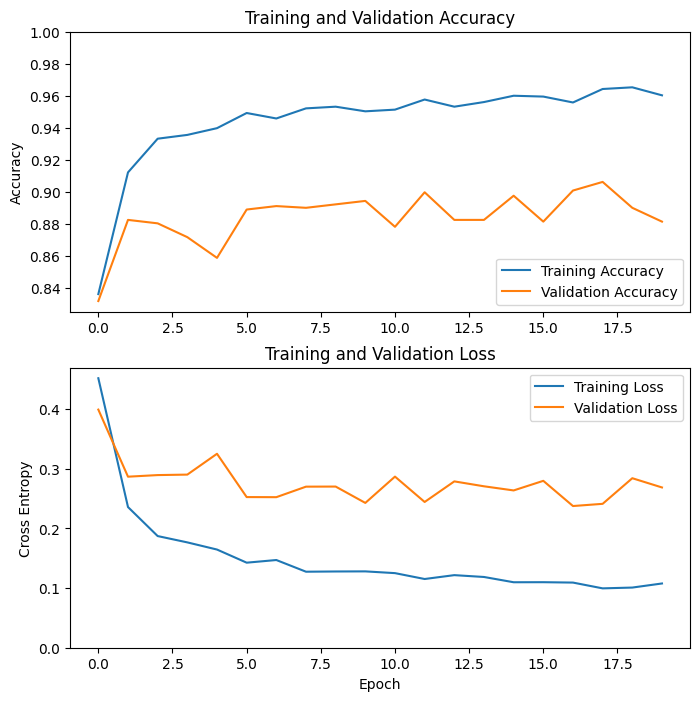

In [ ]:
import matplotlib.pyplot as plt

# Mengambil data akurasi dan loss dari history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Membuat plot untuk akurasi
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# Membuat plot untuk loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

# Menampilkan plot
plt.show()


**Confusion Matrix**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Load the best model
best_model = load_model('model_checkpoint.h5')

# Data generator untuk testing (hanya rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk data testing
test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'Testing'),  # Path ke direktori data uji
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

# Membuat prediksi pada data uji
predictions = best_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Dapatkan label sebenarnya dari test_generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Membuat confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Memplot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

# Menampilkan classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/DataSet_Revisi_Sidang/Testing'